# Лабораторная работа №7 по вычислительной математике
## Применение неявных методов в решении жесткой системы дифференциальных уравнений.
### Выполнил Филиппенко Павел -- студент группы Б01-009

##### Задание X.9.5

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from numba import jit
# import scipy as sp

#### Электрофизиология. Уравнение Бонгоффера-Ван-дер-Поля

$$
\begin{cases}
y_1' = a \left(- \left(\frac{y_1^3}{3} - y_1 \right) + y_2 \right) \\
y_2' = -y_1 - b y_2 + c
\end{cases}
$$

$$y_1(0) = 2, ~~~ y_2(0) = 0$$

В этом уравнении рассматриваются $a = 10^3$ и $a = 10^6$. Коэффициенты $c, b$ таковы, что $0 < c < 1$, $b > 0$.

In [72]:
A = 1e3
# A = 1e6
B = 0.5
C = 1

In [73]:
def f1(y1, y2):
    return A * (-(y1**3 / 3 - y1) + y2)

def f2(y1, y2):
    return -y1 -B*y2 + C

def F(y):
    y1 = y[0]
    y2 = y[1]
    return np.array([
        f1(y1, y2),
        f2(y1, y2)
    ])

In [74]:
# коэффициенты для трехстадийного метода Розенброка
a  = 0.435866521508
p1 = 0.435866521508
p2 = 0.478240833275
p3 = 0.085892645217
beta21 = 0.435866521508
beta31 = 0.435866521508
beta32 = -2.116053335950

In [75]:
@jit
def J(yn, h):
    y1n = yn[0]
    y2n = yn[1]

    df1dx1 = (f1(y1n + h, y2n) - f1(y1n - h, y2n)) / (2*h)
    df1dx2 = (f1(y1n, y2n + h) - f1(y1n, y2n - h)) / (2*h)
    df2dx1 = (f2(y1n + h, y2n) - f2(y1n - h, y2n)) / (2*h)
    df2dx2 = (f2(y1n, y2n + h) - f2(y1n, y2n - h)) / (2*h)

    res = np.array([
        [df1dx1, df1dx2],
        [df2dx1, df2dx2]
    ])
    return res

@jit
def Dn(yn, h):
    E = np.eye(2)
    return E + a * h * J(yn, h/10)

In [76]:
# исходники для решения СЛАУ
import SlaeAPI

In [91]:
#! need to rename this function
def Solution(f, h, t_start, t_end, initial_solution: tuple):
    t = np.linspace(t_start, t_end, int((t_end-t_start)/h+1))
    solution = np.zeros((int((t_end-t_start)/h+1), 2))
    solution[0] = initial_solution
    
    for i in range(len(t)-1):
        # составляем СЛАУ
        slae1 = SlaeAPI.Slae(Dn(solution[i], h), h*f(solution[i]))
        k1 = slae1.Gauss_mthd()
        slae2 = SlaeAPI.Slae(Dn(solution[i], h), h*f(solution[i] + beta21*k1))
        k2 = slae2.Gauss_mthd()
        slae3 = SlaeAPI.Slae(Dn(solution[i], h), h*f(solution[i] + beta31*k1 + beta32*k2))
        k3 = slae3.Gauss_mthd()
        # получаем y_{n+1}
        solution[i+1] = solution[i] + p1*k1 + p2*k2 + p3*k3
    return solution

In [94]:
# h = 0.1
# init_sol = np.array([2, 0])
# t_start = 0
# t_end = 100

# sol = Solution(F, h, t_start, t_end, init_sol)
# y1, y2 = sol.T
# t = np.linspace(t_start, t_end, int((t_end-t_start)/h+1))

In [98]:
e = 8.6
def fq(y):
    x = y[0]
    z = y[1]
    return np.array([z, e * (1 - x**2) * z - x])

In [105]:
h = 0.0001
init_sol = np.array([2, 0])
t_start = 0
t_end = 100

sol = Solution(fq, h, t_start, t_end, init_sol)
x, z = sol.T
t = np.linspace(t_start, t_end, int((t_end-t_start)/h+1))

Text(0, 0.5, 'y2')

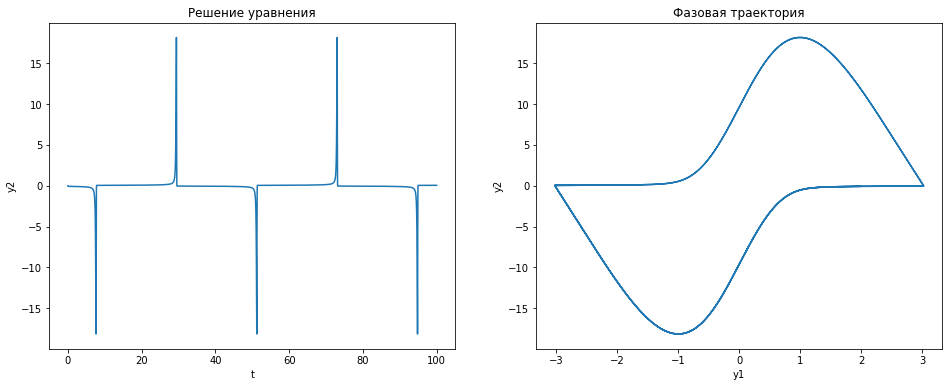

In [106]:
fig = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(t, z)
# plt.scatter(t, y2)
plt.title('Решение уравнения')
plt.xlabel('t')
plt.ylabel('y2')

plt.subplot(1, 2, 2)
plt.plot(x, z)
plt.title('Фазовая траектория')
plt.xlabel('y1')
plt.ylabel('y2')